In [1]:
import os
import numpy as np
import time

import torch
import pickle

import matplotlib.pyplot as plt
import IPython.display as ipd

import warnings
warnings.filterwarnings('ignore')

from scipy.io import wavfile
import scipy.fftpack as fftpack

## Parameters

In [2]:
sample_rate = 44100
frame_sizes = [1024, 2048, 4096]
frame_rate = 100
hop_size = sample_rate/frame_rate
window = [np.hamming(frame_size) for frame_size in frame_sizes]
num_fft_bins = [frame_size >> 1 for frame_size in frame_sizes]

bin_frequencies = []
for i in range(len(frame_sizes)):
    bin_frequencies.append(np.fft.fftfreq(frame_sizes[i], 1. / sample_rate)[:num_fft_bins[i]])


## Functions

In [3]:
def signal_frame(signal, index, frame_size, hop_size, origin=0):
    
    frame_size = int(frame_size)
    num_samples = len(signal)
    ref_sample = int(index * hop_size)
    start = ref_sample - frame_size // 2 - int(origin)
    stop = start + frame_size

    if (stop < 0) or (start > num_samples):
        # window falls completely outside the actual signal, return just zeros
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        return frame
    elif (start < 0) and (stop > num_samples):
        # window surrounds the actual signal, position signal accordingly
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[-start:num_samples - start] = signal
        return frame
    elif start < 0:
        # window crosses left edge of actual signal, pad zeros from left
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[-start:] = signal[:stop, ]
        return frame
    elif stop > num_samples:
        # window crosses right edge of actual signal, pad zeros from right
        frame = np.repeat(signal[:1] * 0, frame_size, axis=0)
        frame[:num_samples - start] = signal[start:, ]
        return frame
    # normal read operation
    return signal[start:stop, ]

def hz2mel(f):
    return 1127.01048 * np.log(np.asarray(f) / 700. + 1.)

def mel2hz(m):
    return 700. * (np.exp(np.asarray(m) / 1127.01048) - 1.)

def mel_frequencies(num_bands, fmin, fmax):
    return mel2hz(np.linspace(hz2mel(fmin), hz2mel(fmax), num_bands))

def frequencies2bins(frequencies, bin_frequencies):
    indices = bin_frequencies.searchsorted(frequencies)
    left = bin_frequencies[indices - 1]
    right = bin_frequencies[indices]
    indices -= frequencies - left < right - frequencies
    return indices

def bins2filterbank(bins, num_fft_bins):
    filterbank = []
    index = 0
    for index in range(len(bins)-2):
        start, center, end = bins[index: index + 3]
        filt = np.zeros(num_fft_bins)
        # rising edge (without the center)
        filt[start:center] = np.linspace(0, 1, center - start, endpoint=False)
        # falling edge (including the center, but without the last bin)
        filt[center:end] = np.linspace(1, 0, end - center, endpoint=False)
        filterbank.append(filt)
    return filterbank

def create_filterbank(bin_frequencies, num_fft_bins, num_bands = 20, fmin = 20., fmax = 17000.):
    frequencies = mel_frequencies(num_bands + 2, fmin, fmax)
    bins = frequencies2bins(frequencies, bin_frequencies)
    filterbank = bins2filterbank(bins, num_fft_bins)
    return np.asarray(filterbank)

def quantize_events(events, fps, length):
    events = np.array(events, dtype=np.float)
    
    events = events[:np.searchsorted(events, float(length - 0.5) / fps)]

    quantized = torch.zeros(length, dtype=torch.long)

    events *= fps
    
    # indices to be set in the quantized array
    idx = np.unique(np.round(events).astype(np.int))
    quantized[idx] = 1

    return quantized

def half_wave_rectifier(arr):
    return (np.abs(arr) + arr) / 2.0

## Feature extraction 

In [4]:
# load files from folder
files = sorted(os.listdir('../data/audio/Ballroom/'))
annotations = sorted(os.listdir('../data/annotations/Ballroom/'))

features = []

filterbank = []
for i in range(len(frame_sizes)):
    filterbank.append(np.array(create_filterbank(bin_frequencies[i], num_fft_bins[i]), dtype='float32'))

normalize = True 

start = time.time()
for i, file in enumerate(files):
    
    print("Progress file {:d} of {:d}".format(i+1, len(files)), end="\r")
    
    # Load audio
    _, signal = wavfile.read('../data/audio/Ballroom/' + file, mmap=False) # is mmap=True necessary ? 
    num_frames = int(np.floor(len(signal) / float(hop_size) + 1))
    
    feature = []
    
    for j, frame_size in enumerate(frame_sizes): 
    
        frames = []    

        # Slice audio into frames
        for index in range(num_frames):
            frames.append(signal_frame(signal, index, frame_size, hop_size))

        # Compute FFT    
        fft = np.empty((num_frames, num_fft_bins[j]), np.complex64)

        for f, frame in enumerate(frames):
            fft_signal = np.multiply(frame, window[j])
            fft[f] = fftpack.fft(fft_signal, frame_size, axis=0)[:num_fft_bins[j]]

        abs_fft = np.square(np.abs(fft))

        filt_spec = np.log(np.dot(abs_fft, filterbank[j].T) + 1.0)
        
        shift_length = np.int(frame_size/100.)
        
        median = [np.pad(filt_spec,((shift, 0), (0, 0)), mode='constant')
                  [:-shift,:] for shift in range(1, shift_length+1)]
        median = np.insert(median, 0, filt_spec, axis=0)
        median = np.median(median, axis=0)
        
        diff_spec = half_wave_rectifier(filt_spec - median)
        diff_spec[:shift_length,:] = 0
        
        if normalize:
            filt_spec = filt_spec - np.min(filt_spec)
            filt_spec = filt_spec / np.max(filt_spec)
            diff_spec = diff_spec - np.min(diff_spec)
            diff_spec = diff_spec / np.max(diff_spec)
               
        feature.append(torch.tensor(filt_spec, dtype=torch.float32)) 
        feature.append(torch.tensor(diff_spec, dtype=torch.float32)) 
      
    features.append(torch.cat(feature, 1))
    
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

Progress file 698 of 698
Elapsed time: 11 min and 7 s


## Save features

In [5]:
start = time.time()
# np.save('../data/numpy/ballroom_features_boeck.npy', features)
pickle.dump(features, open('../data/pickle/ballroom_features_normalized_boeck.npy', 'wb'), protocol=2)
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60),np.int((end - start) % 60)))


Elapsed time: 0 min and 24 s


Elapsed time with mmap: 301.13 s 

Elapsed time without mmap: 245.32

## Create labels 

In [6]:
beats = [np.loadtxt('../data/annotations/Ballroom/' + ann, ndmin=2)[:, 0] for ann in annotations]

labels = [quantize_events(beats[i], fps=frame_rate, length=len(features[i])) for i in range(len(features))]

## Save labels

In [7]:
# np.save('../data/numpy/ballroom_labels.npy', labels)
pickle.dump(labels, open('../data/pickle/ballroom_labels_boeck.npy', 'wb'), protocol=2)

## Example 

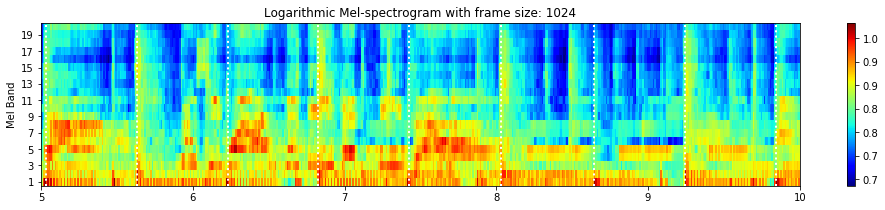

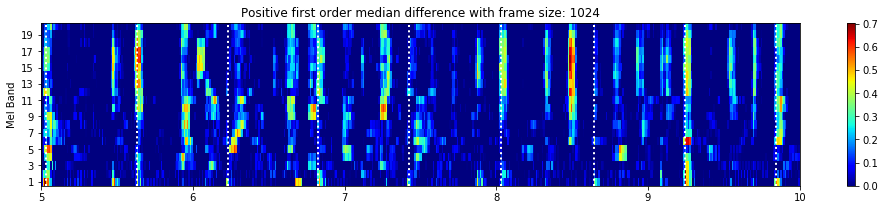

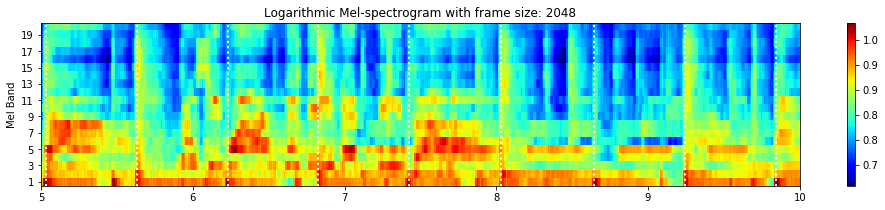

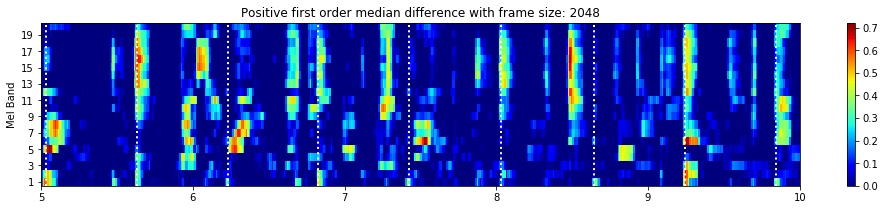

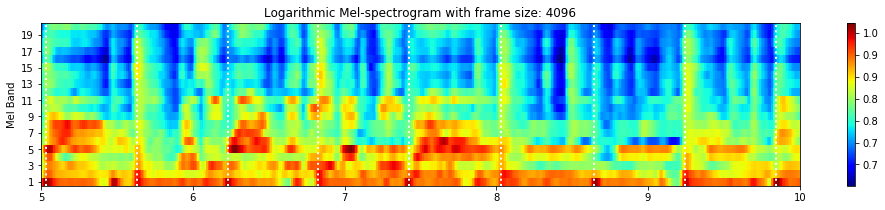

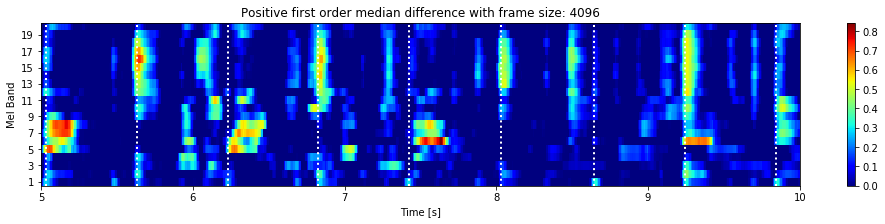

In [8]:
example = 1

file = files[example]
_, signal = wavfile.read('../data/audio/Ballroom/' + file)

start = 5
end = 10
num_bands = 20

title = ['Logarithmic Mel-spectrogram with frame size: 1024', 
         'Positive first order median difference with frame size: 1024',
         'Logarithmic Mel-spectrogram with frame size: 2048', 
         'Positive first order median difference with frame size: 2048',
         'Logarithmic Mel-spectrogram with frame size: 4096', 
         'Positive first order median difference with frame size: 4096']

for i in range(6):
    plt.figure(figsize=(17,3))
    plt.title(title[i])

    plt.imshow(np.array(features[example]).T[i*20:(i+1)*20,start*frame_rate:end*frame_rate], 
               extent=(start,end, 0.5, num_bands+0.5),
               origin='lower', aspect='auto',cmap='jet');
    plt.yticks(np.arange(1,20,2));
    plt.ylim(0.5,num_bands+0.5)

    plt.colorbar(format='%.1f');
    
    plt.ylabel('Mel Band');

    for ann in beats[example]:
        plt.axvline(x=ann, color='w', linestyle=':', linewidth=2)
    plt.xlim(start, end)

plt.xlabel('Time [s]')

ipd.Audio(signal[start*sample_rate:end*sample_rate], rate=sample_rate)

Wie sollen die Features normalisiert werden? <br>
Mit Hinblick auf die Eingangsdaten?

## Appendix

In [9]:
a = np.random.randn(5,3)
print('a:\n', a, '\n')

shift_length = 5

median = [np.pad(a,((shift, 0), (0, 0)), mode='edge')[:-shift,:] for shift in range(1, shift_length+1)]
median = np.insert(median, 0, a, axis=0)

print('median:\n', median)

median = np.median(median, axis=0)

# shift = 1
# np.pad(a,((shift, 0), (0, 0)), mode='edge')[:-1,:]

median

a:
 [[-1.42763961 -0.93727811 -0.40005464]
 [-0.10261665  0.21439471  1.09877195]
 [-0.05127222  0.82291246 -0.52042247]
 [ 0.83887285  0.8513854  -0.97526445]
 [ 1.22862149  1.62917309  1.2183909 ]] 

median:
 [[[-1.42763961 -0.93727811 -0.40005464]
  [-0.10261665  0.21439471  1.09877195]
  [-0.05127222  0.82291246 -0.52042247]
  [ 0.83887285  0.8513854  -0.97526445]
  [ 1.22862149  1.62917309  1.2183909 ]]

 [[-1.42763961 -0.93727811 -0.40005464]
  [-1.42763961 -0.93727811 -0.40005464]
  [-0.10261665  0.21439471  1.09877195]
  [-0.05127222  0.82291246 -0.52042247]
  [ 0.83887285  0.8513854  -0.97526445]]

 [[-1.42763961 -0.93727811 -0.40005464]
  [-1.42763961 -0.93727811 -0.40005464]
  [-1.42763961 -0.93727811 -0.40005464]
  [-0.10261665  0.21439471  1.09877195]
  [-0.05127222  0.82291246 -0.52042247]]

 [[-1.42763961 -0.93727811 -0.40005464]
  [-1.42763961 -0.93727811 -0.40005464]
  [-1.42763961 -0.93727811 -0.40005464]
  [-1.42763961 -0.93727811 -0.40005464]
  [-0.10261665  0.21439

array([[-1.42763961, -0.93727811, -0.40005464],
       [-1.42763961, -0.93727811, -0.40005464],
       [-1.42763961, -0.93727811, -0.40005464],
       [-0.76512813, -0.3614417 , -0.40005464],
       [-0.07694444,  0.51865358, -0.40005464]])